<a href="https://colab.research.google.com/github/felixsimard/comp551-p3/blob/main/Felix_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Felix's Notebook for exploring the assignment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from sklearn import preprocessing

In [2]:
# Reference: https://www.youtube.com/watch?v=pDdP0TFzsoQ

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    plt.imshow(img)
    # plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

In [4]:
def load_data(filename, data_path='/content/drive/MyDrive/P3-COMP551-FALL2021/'):
    from google.colab import drive
    drive.mount("/content/drive")
    loaded_pkl = None
    try:
        pkl_buffered = open(data_path+''+filename,'rb')
        loaded_pkl = pickle.load(pkl_buffered)
    except Exception as e:
        print("Error loading data: {}".format(e))
    return loaded_pkl
    

In [5]:
# Load data
train_l = load_data("images_l.pkl")
train_ul = load_data("images_ul.pkl")
labels_l = load_data("labels_l.pkl")
test_ul = load_data("images_test.pkl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Reference: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [7]:
# Hyper-parameters
NUM_EPOCHS = 4
BATCH_SIZE = 1
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001

In [8]:
# Tensor, Transform, Datasets, Dataloaders

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Tensor
train_l_tensor = torch.Tensor(train_l)


def labelize(lst):
    bin_str = "".join(str(int(i)) for i in lst)
    return bin_str

# Labels logic
labels_l_lst = labels_l.tolist()
labels_l_lst = [labelize(lst) for lst in labels_l_lst]
labels_encoder = preprocessing.LabelEncoder()
targets = labels_encoder.fit_transform(labels_l_lst)
labels_l_tensor = torch.as_tensor(targets)

# labels_l_tensor = torch.argmax(torch.Tensor(labels_l), dim=1) # THIS IS KEY FOR THE LABELS

# Datasets
train_l_dataset = TensorDataset(train_l_tensor, labels_l_tensor)
train_l_dataloader = DataLoader(train_l_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test
test_ul_tensor = torch.Tensor(test_ul)
test_labels = torch.Tensor(np.zeros(len(test_ul)))
test_ul_dataset = TensorDataset(test_ul_tensor, test_labels)
test_ul_dataloader = DataLoader(test_ul_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [9]:
# Define labels
# Consider upper case and lower case letters?
labels = []
for l in range(26):
    letter_str = [0.0 for i in range(26)]
    letter_str[l] = 1.0
    for d in range(10):
        digits_str = [0.0 for j in range(10)]
        digits_str[d] = 1.0
        c = digits_str + letter_str
        # c = "".join(c_str)
        labels.append(c)
print(labels[:5])
print(len(labels))

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
260


In [10]:
# Implement CONV Net

class ConvNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=260):
        super(ConvNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # self.model = torchvision.models.resnet34(pretrained=False)
        self.conv1 = nn.Conv2d(in_channels, 6, 5) # input channel (rgb), output channel, kernel size 
        self.pool = nn.MaxPool2d(2, 2) # define 2x2 stride for max-pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # input channel size = output channel size of previous conv layer
        self.fc1 = nn.Linear(16*11*11, 120) # fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)   
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # activation function does not change size
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*11*11) # -1 tells PyTorch to infer num batches # flatten tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no activation at end, softmax included in CrossEntropyLoss
        return x





In [11]:
# Test model flow
model_test = ConvNet()
x = torch.randn(BATCH_SIZE, 1, 56, 56)
print(model_test(x).shape)

torch.Size([1, 260])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss() # includes softmax
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

n_total_steps = len(train_l_dataloader)

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_l_dataloader, 0):
        # get inputs, data is a list of [inputs, labels]
        inputs = data[0].to(device)[None, :]
        inputs = inputs.permute(1, 0, 2, 3)
        labels = data[1].to(device)

        # print("Inputs:", inputs.shape)
        # print("labels:", labels)
        # print("labels:", labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0: # print every 1000 mini-batches
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_l_dataloader)}], Loss: {loss.item():.4f}')
            running_loss = 0.0
        

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/4], Step [100/30000], Loss: 5.3697
Epoch [1/4], Step [200/30000], Loss: 5.6379
Epoch [1/4], Step [300/30000], Loss: 5.5275
Epoch [1/4], Step [400/30000], Loss: 5.5601
Epoch [1/4], Step [500/30000], Loss: 5.5714
Epoch [1/4], Step [600/30000], Loss: 5.3932
Epoch [1/4], Step [700/30000], Loss: 4.9531
Epoch [1/4], Step [800/30000], Loss: 5.6342
Epoch [1/4], Step [900/30000], Loss: 5.3941
Epoch [1/4], Step [1000/30000], Loss: 5.6612
Epoch [1/4], Step [1100/30000], Loss: 5.5638
Epoch [1/4], Step [1200/30000], Loss: 5.7147
Epoch [1/4], Step [1300/30000], Loss: 5.4615
Epoch [1/4], Step [1400/30000], Loss: 5.6259
Epoch [1/4], Step [1500/30000], Loss: 5.6782
Epoch [1/4], Step [1600/30000], Loss: 5.7370
Epoch [1/4], Step [1700/30000], Loss: 5.6761
Epoch [1/4], Step [1800/30000], Loss: 5.7469
Epoch [1/4], Step [1900/30000], Loss: 5.5963
Epoch [1/4], Step [2000/30000], Loss: 5.6485
Epoch [1/4], Step [2100/30000], Loss: 5.2064
Epoch [1/4], Step [2200/30000], Loss: 5.5256
Epoch [1/4], Step [

In [13]:
# Predict 

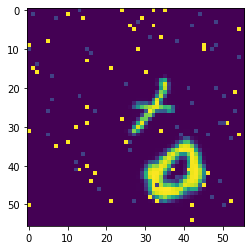

In [14]:
images, labels = next(iter(test_ul_dataloader))
imshow(images[0]) # torchvision.utils.make_grid(images[0])

In [15]:
# Setup CSV for predictions export
df = pd.DataFrame(columns=['# Id', 'Category'])

In [21]:
with torch.no_grad():
    i = 0
    for data in test_ul_dataloader:
        images, labels = data
        images = data[0].to(device)[None, :]
        images = images.permute(1, 0, 2, 3)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        label_predicted = labels_encoder.inverse_transform([predicted.item()])
        prediction = str(label_predicted[0])
        df.loc[i] = [i, prediction]
        i += 1

In [22]:
# Export CSV for Kaggle
from datetime import datetime
filename = 'kaggle_g19_{}.csv'.format(datetime.now())
df.to_csv(filename, sep=',', float_format='{:36}', index=False)

In [92]:
# test_df = pd.DataFrame(columns=['# Id', 'Category'])
# test_df.loc[0] = [1, '00010001000000000']
# test_df.to_csv('testcsv.csv', sep=',', float_format='{:36}', index=False)